In [1]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d
import pandas as pd
import numpy as np
%matplotlib inline

/Library/Python/2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# LCDM

Resolver:

$\dot \rho_i + 3(1+\gamma)H\rho_i = 0$

$H^2 = \frac{\kappa_0}{3}\sum \rho_i$

Cambiando variables, a:

$\Omega_i = \frac{\kappa_0 }{3H^2} \rho_i$ 

In [15]:
#Condiciones iniciales
Or = 0.0001
Om = 0.0
Ol = 1. - Or - Om
H0 = 70.

In [16]:
#Right hand side of the equations
def RHS(Omega_i, lna, gamma=0):
    x, y, z, H = Omega_i
    pi = 3*x + 4*y
    return [x*(-3 + pi), y*(-4 + pi), z*pi, -0.5*H*pi]

## Omegas

In [17]:
y0     = [Om, Or, Ol, H0]

#Intervalo muy grande, solo para visualizacion de \Omegas
lna    = np.linspace(0, -12, 300)
result = odeint(RHS, y0, lna)

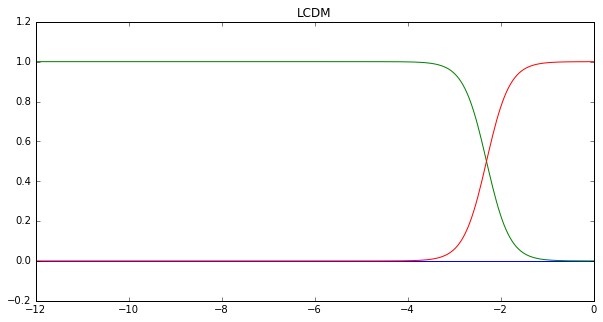

In [18]:
plt.figure(figsize=(10,5))
for i in [0,1,2]:
    plt.plot(lna, result.T[i])
plt.title('LCDM')
#plt.savefig('Omegas_LCDM.jpg')

## Hubble

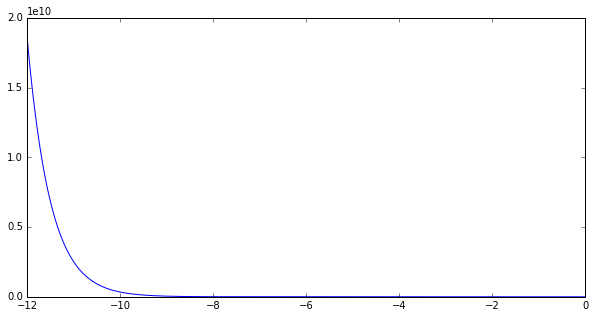

In [19]:
plt.figure(figsize=(10,5))
plt.plot(lna, result.T[3])

In [20]:
#Interpolando, solo en el intervalo z=[0,2]
z     = np.exp(-lna)-1.
zvals = np.linspace(0.01, 2, 300)
H_z   = np.interp(zvals, z, result.T[3])

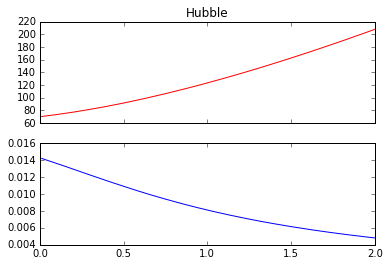

In [8]:
plt.figure(figsize=(10,5))
f, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.set_title('Hubble')
ax1.plot(zvals, H_z, color ='red')
ax2.plot(zvals, 1./H_z, color ='blue')

## Data

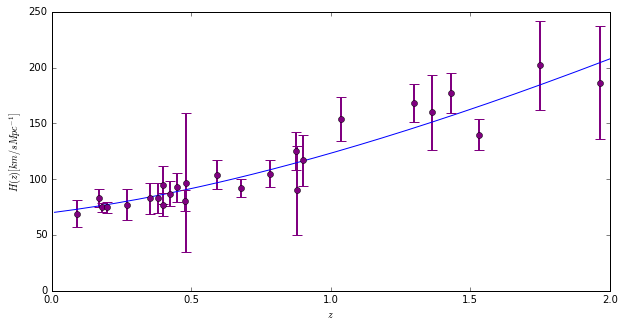

In [9]:
plt.figure(figsize=(10,5))
plt.plot(zvals, H_z, color ='blue')
# Data
dataHz = np.loadtxt('Hz_all.dat')
redshifts, obs, errors = [dataHz[:,i] for i in [0,1,2]]
plt.errorbar(redshifts, obs, errors,      #plt.errorbar(x, y, error_y)
             xerr=None, 
             color='purple', marker='o', ls='None', 
             elinewidth =2, capsize=5, capthick = 1, 
             label='$Datos$')
plt.xlabel(r'$z$')                            
plt.ylabel(r'$H(z) [km/s Mpc^{-1}]$') 

In [10]:
def hubble_inv(x):
    return H0/H_z[x]

In [11]:
xi = np.array([quad(hubble_inv, 0, i)[0] for i in zvals])
dl = (1+zvals)*xi
mu = 5*np.log10(dl*4000)+25 

/Library/Python/2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


In [12]:
names = ['name', 'z', 'mu', 'error']
result = pd.read_table('sn_z_mu_dmu_union2.txt', sep='\s+', names=names, index_col='z')
result=result.sort_index()

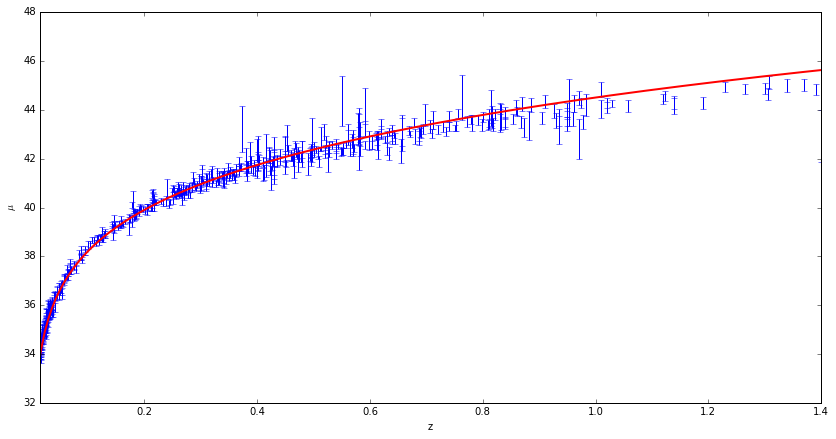

In [14]:
plt.figure(figsize=(14,7))
result['mu'].plot(yerr=result['error'], linestyle='None')
plt.plot(zvals, mu, color='red', lw=2)
plt.ylabel(r'$\mu$') 
plt.savefig('SNs.pdf')

# Campos escalares - 1er intento

In [128]:
#Condiciones iniciales
Or0 = 0.0001
Om0 = 0.3
y0 = 0.01
x0 = np.sqrt(1. - Or0 - Om0 - y0**2)
H0 = 0.70
 

In [104]:
#Right hand side of the equations
def RHS(Omega_i, lna, gamma=0):
    lam=40.
    Om, Or, x, y, H = Omega_i
    pi = -0.5*(3*Om + 4*Or + 6*x**2)
    return [Om*(-3 - 2*pi), Or*(-4 - 2*pi), -3*x + lam*y -x*pi, -lam*x*y -y*pi, H*pi]

In [105]:
vec0     = [Om0, Or0, x0, y0, H0]
lna    = np.linspace(0, -5, 300)
result = odeint(RHS, vec0, lna)

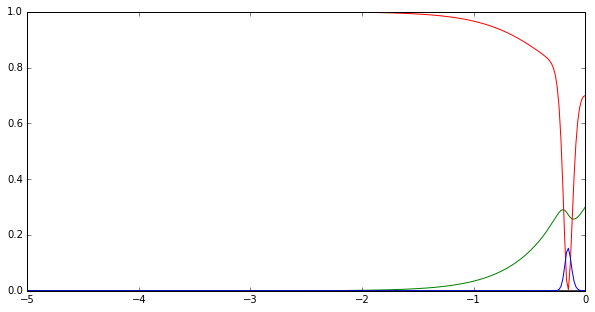

In [106]:
plt.figure(figsize=(10,5))
plt.plot(lna, result.T[0], color='green')
plt.plot(lna, result.T[1], color='k')
plt.plot(lna, result.T[2]**2, color='red')
plt.plot(lna, result.T[3]**2, color='blue')

# Campos escalares - 2do intento

In [185]:
lna = np.linspace(-12, 0, 300)
def Pot(x, i, lam=2):
    V0=500
    V= V0*np.exp(-lam*x)
    if i==0:
        return V
    if i==1:
        return -lam*V

In [186]:
def hub(lna, x_vec):
    a=np.exp(lna)
    x,y= x_vec
    return np.sqrt(0.5*y**2 + Pot(x,0)/(3*H0**2) + Om0/a**3 + Or0/a**4)

def RHS(x_vec, lna):
    x, y = x_vec
    return [np.sqrt(3.0)*y/hub(lna,x_vec), -3*y -Pot(x,1)/(np.sqrt(3.)*H0*hub(lna,x_vec))]

def solver(x0, vpo):
    y0 = [x0, vpo]
    y_result = odeint(RHS, y0, lna, h0=1E-10)
    return y_result

In [187]:
for i in range(10):
    a, b= solver(i,0).T
    Ol=  (0.5*b[-1]**2+Pot(a[-1],0)/(3*H0**2))/hub(0.0, [a[-1],b[-1]])**2
    print Ol

0.887985853209
0.857817311197
0.783809321987
0.590087849292
0.245891502331
0.0478375914088
0.00689304567138
0.000941150924943
0.000127524258567
1.7261344619e-05


In [188]:
def Ini_phi():
    lowr, highr = 0, 30
    tol, tol1 =101, 100
    Ttol= 5e-3
    count=0
                                        #search initial conditions
    if True:
        while (abs(tol)>Ttol):
            mid= (lowr+highr)/2.0
            sol = solver(mid, 0.0)
            xx, yy = sol.T
            
            Omegal=  (0.5*yy[-1]**2+Pot(xx[-1],0)/(3*H0**2))/hub(0.0, [xx[-1],yy[-1]])**2
            tol = Omegal - 0.7 # Omegal #(1.0-self.Om) - Omegal
            print Omegal, mid, tol
            if(abs(tol) < Ttol):
                #print 'reach tolerance', abs(tol), count
                break
            else:
                if(tol<0):
                    highr = mid
                else:
                    lowr = mid

            count+=1
            if (count > 30):
                print 'No solution found!'
                break
            
        #print 'mid', self.lB, self.lam, self.A
        #sol =self.solver(0., self.V0)
        print 'O_L calc', Omegal
        #self.sol =sol
        #xx, yy = sol.T
        #self.Ophi = interp1d(self.lna, (0.5*yy**2+self.Pot(xx,0)/self.Cte**2))
        #self.hubble=interp1d(self.lna, (self.hub(self.lna, sol.T))**2)
        return xx, yy

In [189]:
xx, yy = Ini_phi()

1.06060144843e-10 15.0 -0.699999999894
0.000346534632714 7.5 -0.699653465367
0.331823700004 3.75 -0.368176299996
0.797385105249 1.875 0.0973851052489
0.640750204622 2.8125 -0.0592497953782
0.736514560121 2.34375 0.0365145601212
0.693821861895 2.578125 -0.00617813810456
0.716369070079 2.4609375 0.0163690700791
0.705408863102 2.51953125 0.00540886310222
0.699695293672 2.548828125 -0.000304706327824
O_L calc 0.699695293672


In [190]:
Ophi = interp1d(lna, (0.5*yy**2 + Pot(xx,0)/(3*H0**2)))
O_1 = interp1d(lna, (0.5*yy**2))
O_2 = interp1d(lna, (Pot(xx,0)/(3*H0**2)))
Hz =  hub(lna, [xx,yy])
oo = Ophi(lna) 
oo_1 = O_1(lna)
oo_2 = O_2(lna)


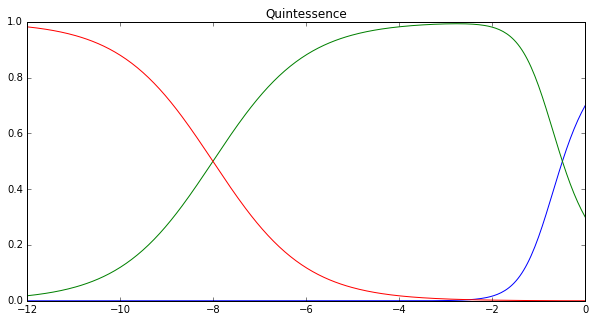

In [191]:
plt.figure(figsize=(10,5))
plt.plot(lna, oo/hub(lna, [xx,yy])**2)
plt.plot(lna, Om0/np.exp(lna)**3/hub(lna, [xx,yy])**2)
plt.plot(lna, Or0/np.exp(lna)**4/hub(lna, [xx,yy])**2)
#for i in [0,1,2]:
#    plt.plot(lna, result_lcdm.T[i], 'o', label='LCDM')
plt.title('Quintessence')
#plt.savefig('Omegas_V.jpg')

In [192]:
v_phi = Pot(xx,0)/(3*H0**2)#/hub(lna, [xx,yy])**2
phi_dot =(0.5*yy**2)#/hub(lna, [xx,yy])**2

In [193]:
z     = np.exp(-lna)-1.
zvals = np.linspace(0.01, 2, 100)
H_z   = np.interp(zvals, z[::-1], Hz[::-1]*70)
ipot   = np.interp(zvals, z[::-1], v_phi[::-1])
iphi_dot   = np.interp(zvals, z[::-1], phi_dot[::-1])

# Contribuciones

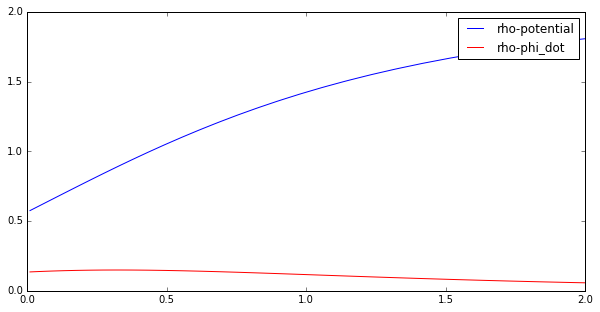

In [194]:
plt.figure(figsize=(10,5))
plt.plot(zvals, ipot, color ='blue', label = 'rho-potential')
plt.plot(zvals, iphi_dot, color ='red', label = 'rho-phi_dot')
plt.legend()
#plt.savefig('rhos_V.jpg')

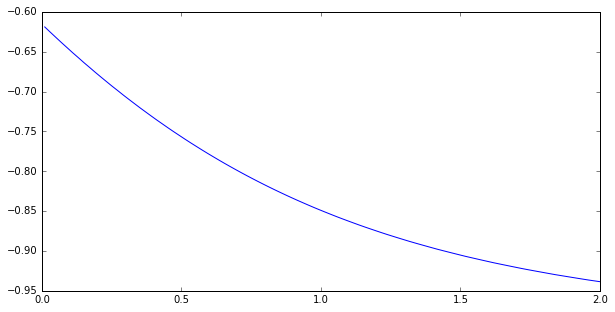

In [195]:
plt.figure(figsize=(10,5))
plt.plot(zvals, (iphi_dot - ipot)/(iphi_dot + ipot), color ='blue', label = 'rho-potential')
#plt.plot(zvals, iphi_dot + ipot, color ='red', label = 'rho-phi_dot')
#plt.legend()
#plt.savefig('rhos.pdf')

## Doing a Forecast (simulating noise - Gaussian)

In [196]:
noise = np.random.normal(0,5,100)

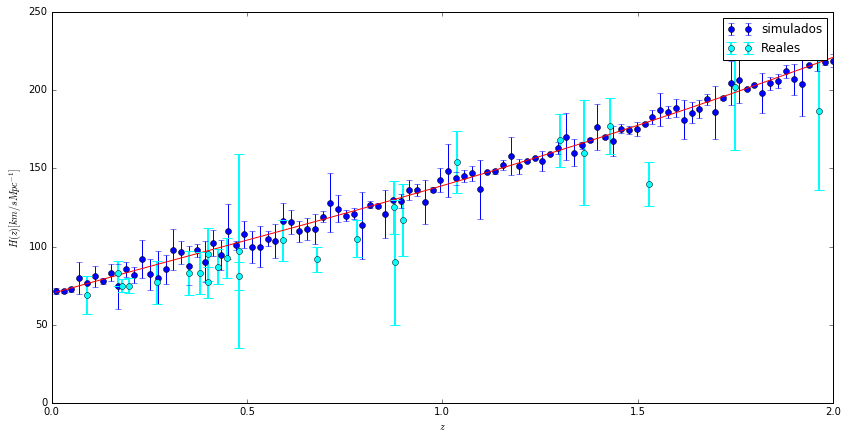

In [197]:
plt.figure(figsize=(14,7))
plt.errorbar(zvals, H_z+noise, noise*2, marker='o', color ='blue', label = 'simulados', linestyle = 'None')
plt.plot(zvals, H_z, color ='red')#'V0 =5000, lam=0.2')
plt.xlabel(r'$z$')                            
plt.ylabel(r'$H(z) [km/s Mpc^{-1}]$') 
plt.errorbar(redshifts, obs, errors,      #plt.errorbar(x, y, error_y)
             xerr=None, 
             color='cyan', marker='o', ls='None', 
             elinewidth =2, capsize=5, capthick = 1, 
             label='Reales')
plt.legend()
#plt.savefig('Hz_V.jpg')

In [198]:
np.savetxt('myfile.txt', np.c_[zvals, H_z+noise, noise*2])

## Siguiente paso: 
    * Revisar calculos
    * Sacarlo del Notebook, usar editor real

# Quintom 1er intento

In [1907]:
lna = np.linspace(-15, 0, 300)
def Pot_phi(x, i, lam=4): #4
    #V0=500.
    #V= V0*np.exp(-lam*x)
    V = 0.5*(lam*x)**2
    if i==0:
        return V
    if i==1:
        return lam**2*x #-lam*V
    
def Pot_psi(x, i, lam=2): #1
    #V0=250.
    #V= V0*np.exp(-lam*x)
    V = 0.5*(lam*x)**2
    if i==0:
        return V
    if i==1:
        return lam**2*x #-lam*V

In [1908]:
def hub(lna, x_vec):
    a=np.exp(lna)
    x,y,u,w= x_vec
    return np.sqrt(0.5*y**2 + Pot_phi(x,0)/(3*H0**2) - 0.5*w**2 + Pot_psi(u,0)/(3*H0**2) + Om0/a**3 + Or0/a**4)

def RHS(x_vec, lna):
    x, y, u, w = x_vec
    return [np.sqrt(3.0)*y/hub(lna,x_vec), -3*y -Pot_phi(x,1)/(np.sqrt(3.)*H0*hub(lna,x_vec)),
             np.sqrt(3.0)*w/hub(lna,x_vec), -3*w +Pot_psi(u,1)/(np.sqrt(3.)*H0*hub(lna,x_vec))]

def solver(x0, vpo, u0, wp0):
    y0 = [x0, vpo, u0, wp0]
    y_result = odeint(RHS, y0, lna, h0=1E-10)
    return y_result

In [1957]:
aa, bb, cc, dd= solver(0.6 ,0, 0.2, 0).T  #0.3, 0, 1.2, 0
Oml  = 0.5*bb**2 + Pot_phi(aa,0)/(3*H0**2) - 0.5*dd**2 + Pot_psi(cc,0)/(3*H0**2)
Ophi = interp1d(lna,  Oml)
Hz =  hub(lna, [aa,bb,cc,dd])
oo = Ophi(lna) 

In [1958]:
w_1  = 0.5*bb**2 - Pot_phi(aa,0)/(3*H0**2) - 0.5*dd**2 - Pot_psi(cc,0)/(3*H0**2)
w_2  = 0.5*bb**2 + Pot_phi(aa,0)/(3*H0**2) - 0.5*dd**2 + Pot_psi(cc,0)/(3*H0**2)
w_lam = interp1d(lna, w_1/w_2)
w_oo = w_lam(lna)

In [1959]:
z     = np.exp(-lna)-1.
zvals = np.linspace(0.01, 3., 100)
w_f2   = np.interp(zvals, z[::-1], w_oo[::-1])

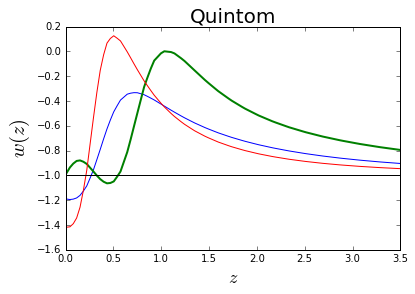

In [1969]:
plt.plot(zvals, w_f, 'b')
plt.plot(zvals, w_f3, 'g', linewidth=2)
plt.plot(zvals, w_f2, 'r')
#plt.plot(zvals, w_g, 'y')
plt.plot([0,3.5],[-1,-1], 'k')
plt.xlim((0,3.5))
plt.title('Quintom',fontsize=20)
plt.ylabel('$w(z)$', fontsize=20)
plt.xlabel('$z$', fontsize=18)
#plt.savefig('Quintom.pdf')

In [1814]:
for i in range(1,20,1):
    a, b, c, d= solver(i,1, 3, 1).T
    Ol=  (0.5*b[-1]**2+Pot_phi(a[-1],0)/(3*H0**2)/hub(0.0, [a[-1],b[-1],c[-1],d[-1]])**2
        - 0.5*d[-1]**2+Pot_psi(c[-1],0)/(3*H0**2)/hub(0.0, [a[-1],b[-1],c[-1],d[-1]])**2)
    print i, Ol

1 0.96958806343
2 3.64845784894
3 5.34879945453
4 5.88842803571
5 6.10861147426
6 6.21906379666
7 6.28236949994
8 6.32209172762
9 6.34869382611
10 6.36740444539
11 6.38107765594
12 6.39138071876
13 6.39934188984
14 6.4056240334
15 6.41067028773
16 6.41478613169
17 6.41818800376
18 6.42103264116
19 6.42343593864


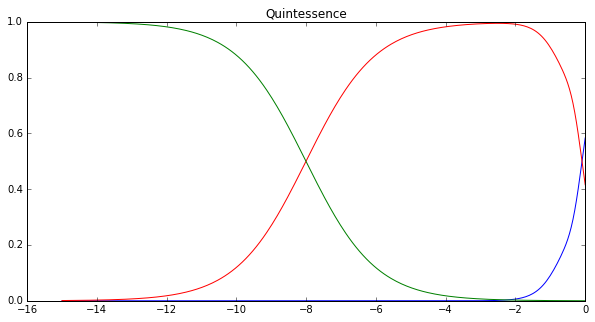

In [1329]:
plt.figure(figsize=(10,5))
plt.plot(lna, oo/hub(lna, [aa,bb,cc,dd])**2, 'b')
plt.plot(lna, Om0/np.exp(lna)**3/hub(lna, [aa,bb,cc,dd])**2,'r')
plt.plot(lna, Or0/np.exp(lna)**4/hub(lna, [aa,bb,cc,dd])**2, 'g')
#for i in [0,1,2]:
#    plt.plot(lna, result_lcdm.T[i], 'o', label='LCDM')
plt.title('Quintessence')
#plt.savefig('Omegas_V.jpg')

In [473]:
from scipy.integrate import quad, trapz
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import derivative
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
%matplotlib inline

In [566]:
zvals = np.linspace(0.01, 4, 50)

In [567]:
def c_z(z):
    return intep_c(z)

In [568]:
%timeit [intep_c(i,1) for i in zvals]

100 loops, best of 3: 3.95 ms per loop


In [569]:
def int_L(z):
    return c_z(z)/(1+z) #-12*c_z(z)/(1+z) - derivative(c_z, z, dx=1e-6)

In [570]:
def intep_c(z, inte=1, a=0, b=0, c=0):
    if (z>=0.0 and z<=4.0):
        y = [ 0.5,  -0.5, 0.5 , 0.0]
        x = [ 0.0 ,  1.0    , 3.0 , 4.0    ]
        if inte == 1: f = interp1d(x, y, kind='linear')    
        if inte == 2: f = interp1d(x, y, kind='cubic') #UnivariateSpline(x,y)
        return f(z)
    

In [571]:
x = intep_c(1.0)

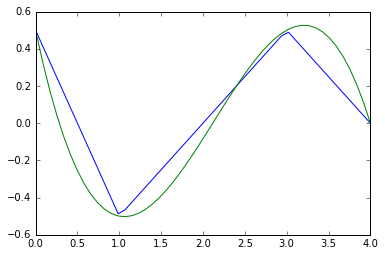

In [572]:
#for a in range(10):
plt.plot(zvals, [intep_c(i, inte=1) for i in zvals])
plt.plot(zvals, [intep_c(i, inte=2) for i in zvals])
#plt.plot([ 0.0    , 2.0    , 3 , 4.0    ], [ 0.1, 0.3, -0.3 , 0.5], 'o')

In [573]:
xi = np.array([6*quad(int_L,0, i)[0] -c_z(i) + 0.7 for i in zvals])

In [521]:
def ftest():
    a =[]
    for i in np.linspace(0.01, 4, 100):
        a.append(trapz([int_L(i) for i in np.linspace(0.01, i, 100)], np.linspace(0.01, i, 100)))
    return a    

In [523]:
f =interp1d(zvals, ftest(), kind='linear')

In [527]:
f([0.1,1])

array([ 0.00378621,  0.00347986])

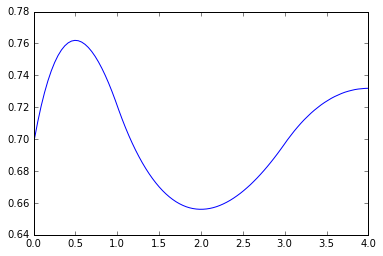

In [518]:
plt.plot(zvals, 6.*np.array(ftest())-c_z(i) + 0.7)

In [574]:
len(xi), len(zvals)

(50, 50)

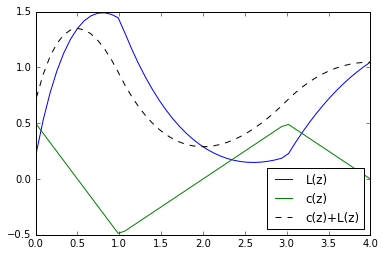

In [575]:
plt.plot(zvals, xi, label='L(z)')
plt.plot(zvals, [c_z(i) for i in zvals], label = 'c(z)')
plt.plot(zvals, xi + [c_z(i) for i in zvals], 'k--', label = 'c(z)+L(z)')
#plt.plot(zvals, 6.*np.array(ftest())-c_z(i) + 0.7, 'red')
plt.legend(loc ='lower right')

In [ ]:
plt.plot(zvals, xi, label='L(z)')
plt.plot(zvals, [c_z(i) for i in zvals], label = 'c(z)')
plt.plot(zvals, xi + [c_z(i) for i in zvals], 'k--', label = 'c(z)+L(z)')
plt.legend(loc ='lower right')

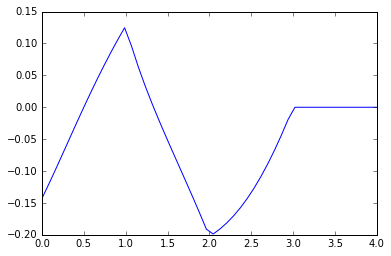

In [356]:
plt.plot(zvals, [c_z(i) for i in zvals]/xi, label = 'c(z)')